<a href="https://colab.research.google.com/github/Sonia-Mokhtari/Deep-Learning/blob/main/Moderately%20Imbalanced/water_quality_moderately_imbalanced_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Load from Google Drive
import pandas as pd
import joblib

from google.colab import drive
drive.mount('/content/drive')

X_train = pd.read_csv("/content/drive/MyDrive/X_train_processed.csv")
X_test = pd.read_csv("/content/drive/MyDrive/X_test_processed.csv")
y_train = pd.read_csv("/content/drive/MyDrive/y_train_processed.csv").squeeze()
y_test = pd.read_csv("/content/drive/MyDrive/y_test_processed.csv").squeeze()

scaler = joblib.load("/content/drive/MyDrive/scaler.pkl")
label_encoders = joblib.load("/content/drive/MyDrive/label_encoders.pkl")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.ensemble import (
    BalancedRandomForestClassifier,
    EasyEnsembleClassifier,
    RUSBoostClassifier
)

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Sample 10% of training data
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.1, stratify=y_train, random_state=42
)

# Cross-validation setup
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
}

# Define models
group1 = {
    'Dummy Classifier': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=25, max_depth=10, n_jobs=-1, random_state=42),
}

group2 = {
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Gaussian Naive Bayes': GaussianNB(),
}

group3 = {
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42),
    'XGBoost': XGBClassifier(eval_metric="mlogloss", n_estimators=50, learning_rate=0.1, max_depth=3, n_jobs=-1, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=50, learning_rate=0.1, max_depth=10,random_state=42, verbose=-1, n_jobs=-1),
}

group4 = {
    'Extra Trees': ExtraTreesClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    'Balanced Random Forest': BalancedRandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42),
    'Easy Ensemble': EasyEnsembleClassifier(n_estimators=10, n_jobs=-1, random_state=42),
}

all_groups = [group1, group2, group3, group4]
all_results = []

# Evaluation function
def evaluate_models(models, X, y, skf, scoring):
    results = {}
    for name, model in models.items():
        print(f"Evaluating {name}...")
        scores = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=False)
        results[name] = {
            'Accuracy': np.mean(scores['test_accuracy']),
            'Precision': np.mean(scores['test_precision']),
            'Recall': np.mean(scores['test_recall']),
            'F1-Score': np.mean(scores['test_f1']),
        }
    return pd.DataFrame(results).T

# Run all evaluations and combine
for i, group in enumerate(all_groups, 1):
    result = evaluate_models(group, X_sample, y_sample, skf, scoring)
    result.to_csv(f"results_group{i}.csv")
    all_results.append(result)

combined_results = pd.concat(all_results)
combined_results.to_csv("all_model_results.csv")

# Final Evaluation on Test Set
print("\n==== Evaluating All Models on Test Set ====")
final_test_results = {}
for model_name in combined_results.index:
    for group in all_groups:
        if model_name in group:
            model = group[model_name]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            final_test_results[model_name] = {
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
                'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
                'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
            }
            break

final_df = pd.DataFrame(final_test_results).T.sort_values(by='F1-Score', ascending=False)
final_df.to_csv("final_test_performance.csv")

Evaluating Dummy Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating KNN...
Evaluating Gaussian Naive Bayes...
Evaluating Gradient Boosting...
Evaluating XGBoost...
Evaluating LightGBM...
Evaluating Extra Trees...
Evaluating Balanced Random Forest...
Evaluating Easy Ensemble...

==== Evaluating All Models on Test Set ====


Test Set Evaluation Summary:
                        Accuracy  Precision    Recall  F1-Score
Dummy Classifier        0.770817   0.594159  0.770817  0.671056
Logistic Regression     0.807622   0.789853  0.807622  0.791020
Decision Tree           0.999993   0.999993  0.999993  0.999993
Random Forest           0.940470   0.942594  0.940470  0.941193
KNN                     0.821866   0.808544  0.821866  0.809966
Gaussian Naive Bayes    0.849156   0.856641  0.849156  0.852124
Gradient Boosting       0.999993   0.999993  0.999993  0.999993
XGBoost                 0.989365   0.989397  0.989365  0.989303
LightGBM                0.996362   0.996361  0.996362  0.996361
Extra Trees             0.864114   0.858438  0.864114  0.854341
Balanced Random Forest  0.938986   0.948502  0.938986  0.940959
Easy Ensemble           0.986419   0.986993  0.986419  0.986533


<Figure size 1200x600 with 0 Axes>

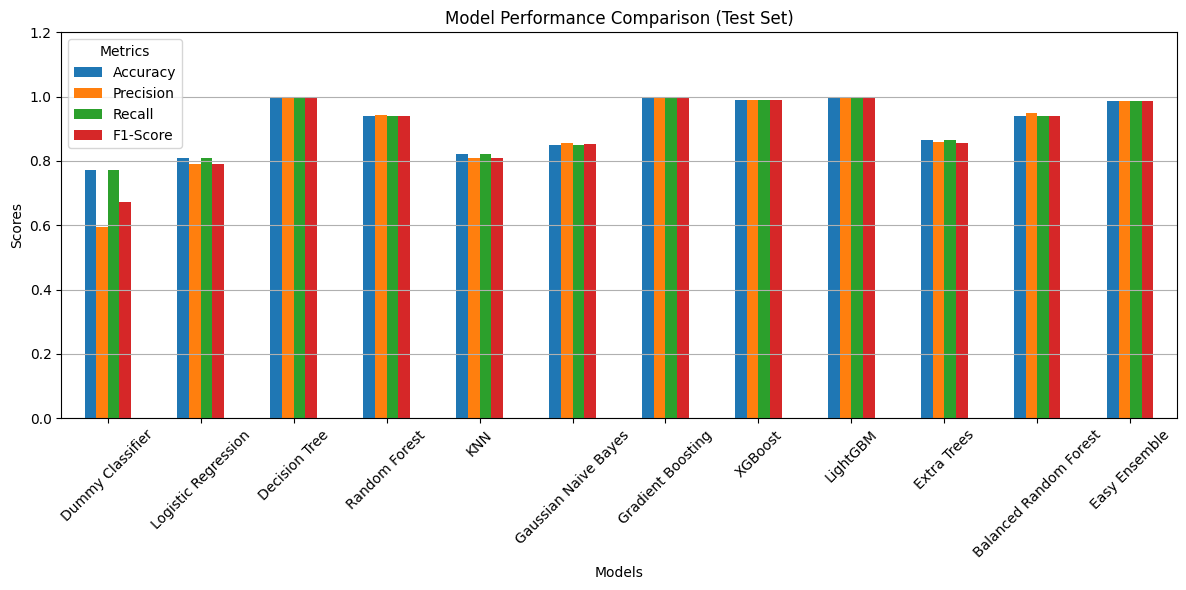

In [7]:
# Convert final test results to DataFrame
final_df = pd.DataFrame(final_test_results).T
final_df = final_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]  # Reorder for consistency

# Save to CSV
final_df.to_csv("final_test_metrics_all_models.csv")

# Print summary
print("Test Set Evaluation Summary:")
print(final_df)

# Plot grouped bar chart of test set performance
plt.figure(figsize=(12, 6))
final_df.plot(kind='bar', figsize=(12, 6))

# Customize bar chart appearance
plt.title('Model Performance Comparison (Test Set)')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1.2)
plt.legend(title='Metrics', loc='best')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_test_performance_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


In [8]:
# Convert the final test results into a clean DataFrame
test_results_list = []

# Loop through all final test results
for model_name, metrics in final_df.iterrows():
    row = {
        "Model": model_name,
        "Accuracy": metrics["Accuracy"],
        "F1-Score": metrics["F1-Score"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"]
    }
    test_results_list.append(row)

# Create DataFrame and sort by F1-Score
test_results_df = pd.DataFrame(test_results_list)
test_results_df = test_results_df.sort_values(by="F1-Score", ascending=False)
test_results_df["Rank"] = test_results_df["F1-Score"].rank(ascending=False).astype(int)

# Reset index
test_results_df.reset_index(drop=True, inplace=True)

# Round for readability
test_results_df[["Accuracy", "F1-Score", "Precision", "Recall"]] = test_results_df[
    ["Accuracy", "F1-Score", "Precision", "Recall"]
].round(3)

# Display nicely
from IPython.display import display
display(test_results_df)

# Save to CSV
test_results_df.to_csv("sorted_test_model_performance.csv", index=False)

,Model,Accuracy,F1-Score,Precision,Recall,Rank
0,Decision Tree,1.000,1.000,1.000,1.000,1
1,Gradient Boosting,1.000,1.000,1.000,1.000,1
2,LightGBM,0.996,0.996,0.996,0.996,3
3,XGBoost,0.989,0.989,0.989,0.989,4
4,Easy Ensemble,0.986,0.987,0.987,0.986,5
5,Random Forest,0.940,0.941,0.943,0.940,6
6,Balanced Random Forest,0.939,0.941,0.949,0.939,7
7,Extra Trees,0.864,0.854,0.858,0.864,8
8,Gaussian Naive Bayes,0.849,0.852,0.857,0.849,9
9,KNN,0.822,0.810,0.809,0.822,10


In [9]:
!pip install seaborn
import seaborn as sns

,Model,Accuracy,F1-Score,Precision,Recall,Rank
11,Dummy Classifier,0.771,0.671,0.594,0.771,12
10,Logistic Regression,0.808,0.791,0.790,0.808,11
9,KNN,0.822,0.810,0.809,0.822,10
8,Gaussian Naive Bayes,0.849,0.852,0.857,0.849,9
7,Extra Trees,0.864,0.854,0.858,0.864,8


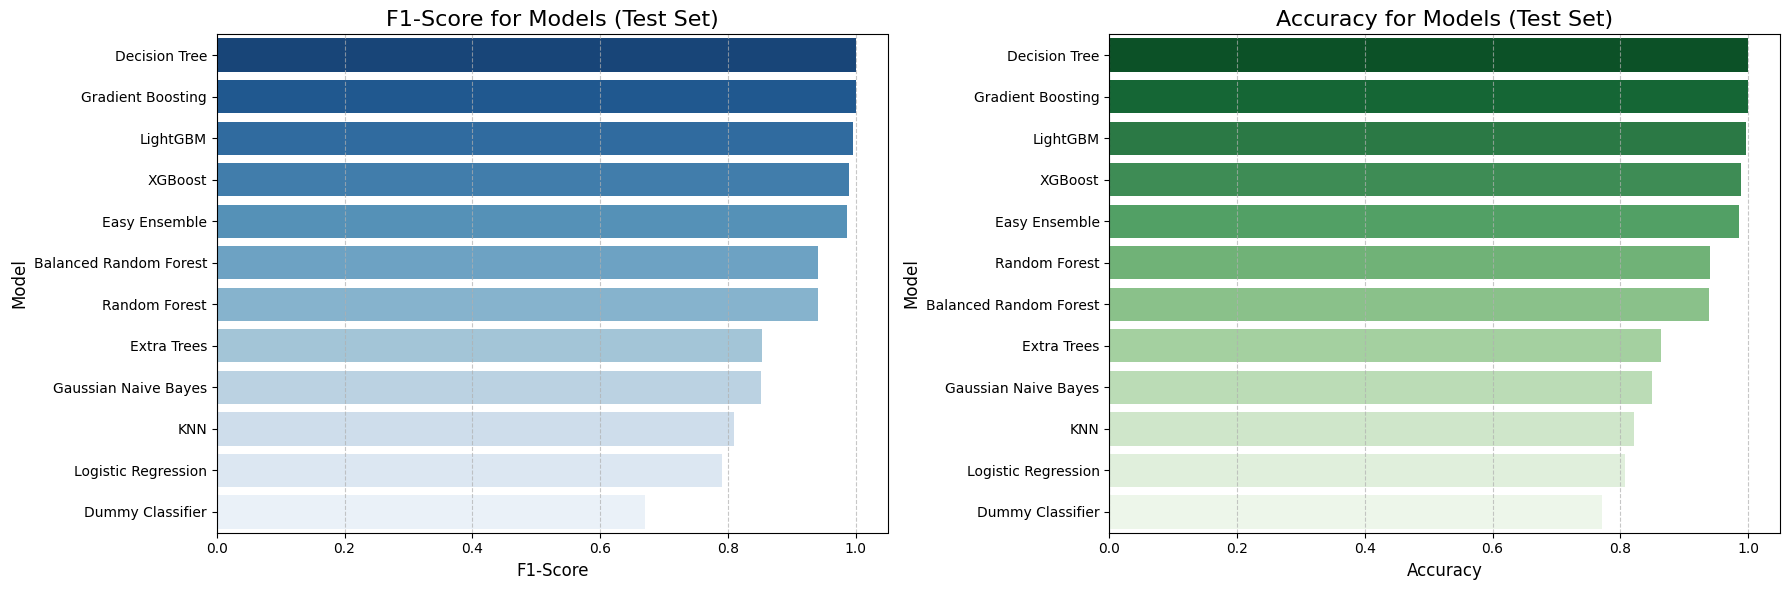

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Optional: Preview the DataFrame before plotting
display(test_results_df.head())

# Sort by F1-Score and Accuracy for clean plots
f1_sorted_df = test_results_df.sort_values(by="F1-Score", ascending=False)
acc_sorted_df = test_results_df.sort_values(by="Accuracy", ascending=False)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1-Score Bar Plot
sns.barplot(
    data=f1_sorted_df,
    x="F1-Score",
    y="Model",
    hue="Model",
    palette="Blues_r",
    dodge=False,
    legend=False,
    ax=axes[0]
)
axes[0].set_title("F1-Score for Models (Test Set)", fontsize=16)
axes[0].set_xlabel('F1-Score', fontsize=12)
axes[0].set_ylabel('Model', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Accuracy Bar Plot
sns.barplot(
    data=acc_sorted_df,
    x='Accuracy',
    y='Model',
    hue='Model',
    palette="Greens_r",
    dodge=False,
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Accuracy for Models (Test Set)", fontsize=16)
axes[1].set_xlabel('Accuracy', fontsize=12)
axes[1].set_ylabel('Model', fontsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

# Final layout and save
plt.tight_layout()
plt.savefig("f1_accuracy_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids

# Define imbalance methods
neighbors = 3
imbalance_methods = {
    "Original Data": None,
    f"SMOTE (k={neighbors})": SMOTE(random_state=42, k_neighbors=neighbors),
    "Random Oversampling": RandomOverSampler(random_state=42),
    f"Borderline-SMOTE (k={neighbors})": BorderlineSMOTE(random_state=42, k_neighbors=neighbors),
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "Tomek Links": TomekLinks(),
    "Cluster Centroids": ClusterCentroids(random_state=42),
    "NearMiss": NearMiss(version=1)
}

In [13]:
# Dictionary to hold results for each imbalance technique
imbalance_results = {}

# Loop through each imbalance method
for method_name, sampler in imbalance_methods.items():
    print(f"\n=== Evaluating with {method_name} ===")

    # Step 1: Resample the 10% training sample
    if sampler:
        X_resampled, y_resampled = sampler.fit_resample(X_sample, y_sample)
    else:
        X_resampled, y_resampled = X_sample.copy(), y_sample.copy()

    method_results = []

    # Step 2: Run model evaluation on all groups using cross-validation
    for i, group in enumerate(all_groups, 1):
        print(f"  → Group {i}")
        result = evaluate_models(group, X_resampled, y_resampled, skf, scoring)
        result.to_csv(f"results_{method_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}_group{i}.csv")
        method_results.append(result)

    # Step 3: Combine all groups and store the full results
    method_combined = pd.concat(method_results)
    method_combined.to_csv(f"all_model_results_{method_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}.csv")
    imbalance_results[method_name] = method_combined



=== Evaluating with Original Data ===
  → Group 1
Evaluating Dummy Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
  → Group 2
Evaluating KNN...
Evaluating Gaussian Naive Bayes...
  → Group 3
Evaluating Gradient Boosting...
Evaluating XGBoost...
Evaluating LightGBM...
  → Group 4
Evaluating Extra Trees...
Evaluating Balanced Random Forest...
Evaluating Easy Ensemble...

=== Evaluating with SMOTE (k=3) ===
  → Group 1
Evaluating Dummy Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
  → Group 2
Evaluating KNN...
Evaluating Gaussian Naive Bayes...
  → Group 3
Evaluating Gradient Boosting...
Evaluating XGBoost...
Evaluating LightGBM...
  → Group 4
Evaluating Extra Trees...
Evaluating Balanced Random Forest...
Evaluating Easy Ensemble...

=== Evaluating with Random Oversampling ===
  → Group 1
Evaluating Dummy Classifier...
Evaluating Logistic Regression...
Evaluating Decision Tr

In [14]:
# Convert all imbalance_results into a unified DataFrame
summary_list = []

for method_name, df in imbalance_results.items():
    for model_name, metrics in df.iterrows():
        summary_list.append({
            "Imbalance Technique": method_name,
            "Model": model_name,
            "Accuracy": metrics["Accuracy"],
            "F1-Score": metrics["F1-Score"],
            "Precision": metrics["Precision"],
            "Recall": metrics["Recall"]
        })

# Create DataFrame
imbalance_summary_df = pd.DataFrame(summary_list)

# Sort for readability
imbalance_summary_df = imbalance_summary_df.sort_values(by=["Imbalance Technique", "F1-Score"], ascending=[True, False])
imbalance_summary_df.reset_index(drop=True, inplace=True)

# Save and display
imbalance_summary_df.to_csv("imbalance_technique_model_summary.csv", index=False)
from IPython.display import display
display(imbalance_summary_df)

,Imbalance Technique,Model,Accuracy,F1-Score,Precision,Recall
0,Borderline-SMOTE (k=3),LightGBM,0.982219,0.982219,0.982239,0.982219
1,Borderline-SMOTE (k=3),Decision Tree,0.963952,0.963952,0.963968,0.963952
2,Borderline-SMOTE (k=3),Gradient Boosting,0.959979,0.959979,0.959982,0.959979
3,Borderline-SMOTE (k=3),Random Forest,0.958450,0.958431,0.959291,0.958450
4,Borderline-SMOTE (k=3),XGBoost,0.953539,0.953536,0.953645,0.953539
...,...,...,...,...,...,...
91,Tomek Links,Extra Trees,0.870091,0.862125,0.865582,0.870091
92,Tomek Links,Gaussian Naive Bayes,0.859141,0.861116,0.863940,0.859141
93,Tomek Links,Logistic Regression,0.817175,0.803163,0.803365,0.817175
94,Tomek Links,KNN,0.816113,0.794960,0.802299,0.816113


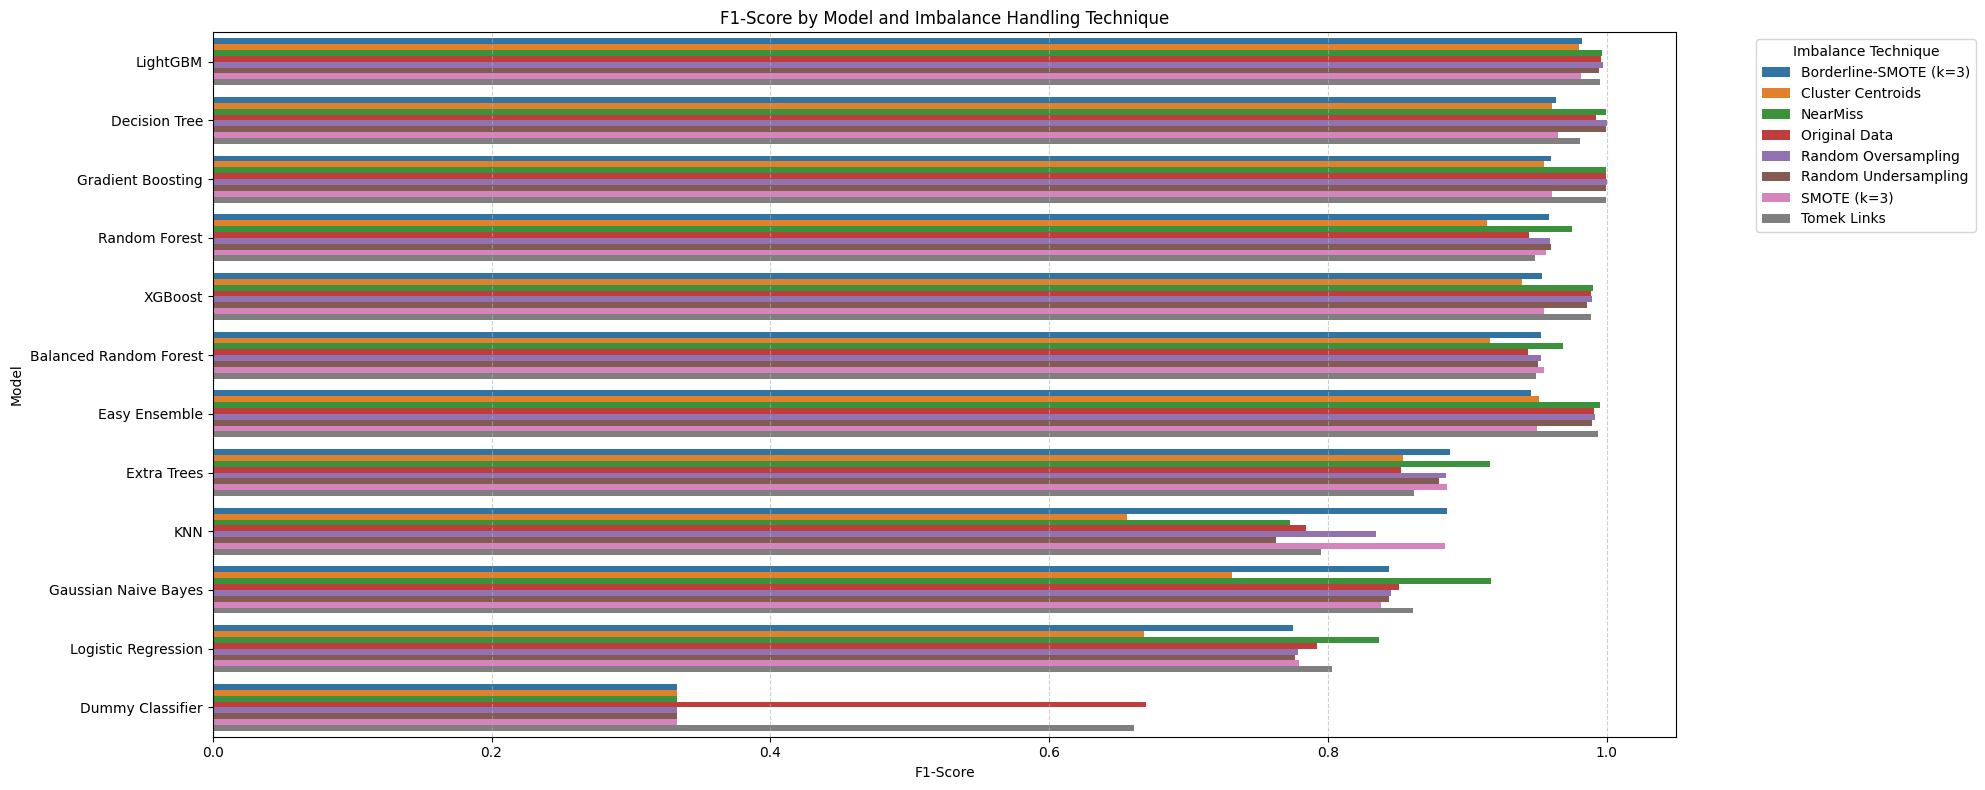

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
sns.barplot(data=imbalance_summary_df, x="F1-Score", y="Model", hue="Imbalance Technique", dodge=True)
plt.title("F1-Score by Model and Imbalance Handling Technique")
plt.xlabel("F1-Score")
plt.ylabel("Model")
plt.legend(title="Imbalance Technique", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("imbalance_techniques_model_comparison.png", dpi=300)
plt.show()

In [16]:
top_combo = imbalance_summary_df.sort_values(by="F1-Score", ascending=False).head(10)
display(top_combo)

,Imbalance Technique,Model,Accuracy,F1-Score,Precision,Recall
48,Random Oversampling,Decision Tree,0.999977,0.999977,0.999977,0.999977
49,Random Oversampling,Gradient Boosting,0.999977,0.999977,0.999977,0.999977
24,NearMiss,Decision Tree,0.999884,0.999884,0.999884,0.999884
25,NearMiss,Gradient Boosting,0.999884,0.999884,0.999884,0.999884
60,Random Undersampling,Decision Tree,0.999806,0.999806,0.999806,0.999806
61,Random Undersampling,Gradient Boosting,0.999806,0.999806,0.999806,0.999806
84,Tomek Links,Gradient Boosting,0.999725,0.999725,0.999725,0.999725
36,Original Data,Gradient Boosting,0.999590,0.999590,0.999590,0.999590
50,Random Oversampling,LightGBM,0.997510,0.997510,0.997511,0.997510
26,NearMiss,LightGBM,0.996361,0.996361,0.996362,0.996361
